In [1]:
using Distributions
using LinearAlgebra
using Plots
using Random
using DelimitedFiles
using ForwardDiff
using HaltonSequences

In [2]:
uniform=Uniform(0,1);

In [3]:
function Af(t)
    temp=1.0/((1.0.+σ^2).+σ^2*(T.-t)); 
    return temp 
end
function Xstar(t)
    denfrac=(σ^2.0.+1.0.+σ^2*T)./(1.0.+σ^2.0.+σ^2*(T.-t))
    temp=t.+(T.^2.0./(2*σ^2) -XT1./σ^2 )*log.(denfrac)
    return temp
end

function rt1(tvec,deno)
    return 0.5*(-tvec.^2).*deno
end

function rt1_v2(tvec)
    return 0.5*(-tvec.^2).*1.0./(1.0.+σ^2.0.+σ^2*(T.-tvec))
end

function denom(tvec)
    return 1.0./(1.0.+σ^2.0.+σ^2*(T.-tvec))
end

denom (generic function with 1 method)

In [4]:
# this matrix compute the inverse of the matrix of interest. 
function mainMat(x0,ntime)
    Nn=length(ntime); 
    mat=zeros(Nn+1,Nn+1); 
    bVec=zeros(Nn+1); 
    
    bprep=Xstar(ntime); 
    
    denr1=denom(ntime); 
    rvec=rt1(ntime,denr1); 
    
    tempX=zeros(Nn+1);
    ucontrol=zeros(Nn);   
    
    for i in collect(1:1:Nn)
        atemp=Af(ntime[i]);
        mat[i,i]=1.0 
        mat[i,i+1]=-1.0 
        mat[i,i:Nn]=mat[i,i:Nn].-atemp*dt2*ones(Nn-i+1)
        
        mat[i,end]=mat[i,end]-atemp*Δt; 
        
        bVec[i]=-(sum(bprep[i:Nn]))*atemp*dt2+rvec[i]*Δt
    end
    mat[Nn+1,1]=1.0;
    bVec[end]=copy(x0); 
    
    tempX=inv(mat)*bVec; 
    ucontrol=(tempX[2:end].-tempX[1:Nn])/Δt.+rvec[1:Nn] 
    return ucontrol
end

function ExactSol(x0,ntime)
    Nn=length(ntime); 
    xtemp=copy(x0); 
    control_output=zeros(Nn); 
    xVec=zeros(Nn+1); xVec[1]=x0; 
    
    
    for i in collect(1:1:Nn)
        timeloc=ntime[i:end];
        controln=mainMat(xtemp,timeloc)
        control_output[i]=controln[1]; 
        
        rval=rt1_v2(ntime[i]);  
        xtemp=xtemp.+ (controln[1]- rval) *Δt.+σ*controln[1].*Wfixed[i]*sqrtt;
        xVec[i+1]=xtemp; 
    end
    return control_output, xVec
end

ExactSol (generic function with 1 method)

## Numerical Part of the problem 

In [5]:
function fx(x,xs)
    l=x.-xs
    return l
end
function Xtraj(xinit_cloud,ntime,nU) 
    #nU has dim  × nN
    nN=length(ntime); 
    Xvec=zeros(nN+1);
    
    rp_index=rand(1:S)
    Xvec[1]=xinit_cloud[rp_index]
    Wvec=randn(nN);
    
    for i in collect(1:1:nN)
       # den_temp=denom(ntime[i]); 
        rval=rt1_v2(ntime[i]);    
        Xvec[i+1]=Xvec[i].+ (nU[i]-rval)*Δt.+σ*nU[i]*Wvec[i]*sqrtt; 
    end
    return Xvec,Wvec
end

function YZ(xvec,uvec,wvec,ntime)
    """
    Returns one backward sample according to the forward sample of X and the corresponding control. 
    """
    wvec_temp=wvec; 
    Nn=length(ntime);   #length(xvec); 
    
    ytemp=zeros(Nn+1); ztemp=zeros(Nn);    
    " according to our scheme, the terminal condition of yT is not 0 anymore "  
    ytemp[end]=xvec[end]; 
       
    for i in collect(Nn:-1:1)
        ztemp[i]=ytemp[i+1].*wvec_temp[i]/sqrtt; 
        ytemp[i]=ytemp[i+1].+Δt*(fx(xvec[i],Xstar(ntime[i])))
    end
    return ytemp,ztemp
end

function jcp(yvec,zvec,xvec,Uvec)
    Nn=length(Uvec);
    temp=zeros(Nn); 
    for i in collect(1:1:Nn)
        temp[i]=yvec[i]+σ*zvec[i]+Uvec[i]
    end
    return temp
end
    
function optimize_loc(xinit_cloud,ntime)
    nN=length(ntime); 
    Uvec=zeros(nN); 
# the threads are only distributed over the closest loop. 
Threads.@threads for i in collect(1:1:L) #  Threads.@threads 
        xvec,Wvec=Xtraj(xinit_cloud,ntime,Uvec); 
        yvec,zvec=YZ(xvec,Uvec,Wvec, ntime);
        Uvec=Uvec.-lr[i]*jcp(yvec,zvec,xvec,Uvec) #jPrime(yvec,Uvec)#.-0.05*jPrime(yvec,Uvec)
    end
    return Uvec
end

function particleDirect(timeVec)
    #U here plays the role of particle cloud
    
    Nn=length(timeVec)
    xtemp=copy(X0);
    
    controlVec=zeros(Nn)
    xtempVec=zeros(Nn+1)
    
    uvec0=zeros(S);
    
    for i in collect(1:1:Nn)
        timeloc=timeVec[i:Nn]; 
        
        controln=optimize_loc(uvec0,timeloc); #finding the control requires the particle cloud
        #collecting the control
        controlVec[i]=controln[1]; 
        
        rval=rt1_v2(timeVec[i]);  
        
        ### The exact movement
        xtemp=xtemp.+ (controln[1]- rval) *Δt.+σ*controln[1].*Wfixed[i]*sqrtt; 
        uvec0=ones(S)*xtemp;
        xtempVec[i+1]=xtemp
    end
    return xtempVec,controlVec
end

particleDirect (generic function with 1 method)

In [6]:
function particleF(timeVec)
    #U here plays the role of particle cloud
    
    nN=length(timeVec)
    U=zeros(nN+1,S)
    Uhat=zeros(S)
    U[1,:]=X0.+0.05*randn(S);
    xtemp=copy(X0);
    
    controlVec=zeros(nN)
    
    for i in collect(1:1:nN)
        timeloc=timeVec[i:nN]; 
        
        controln=optimize_loc(U[i,:],timeloc); #finding the control requires the particle cloud
        #collecting the control
        controlVec[i]=controln[1]; 
        
        rval=rt1_v2(timeVec[i]);  
        
        ### The exact movement
        xtemp=xtemp.+ (controln[1]- rval) *Δt.+σ*controln[1].*Wfixed[i]*sqrtt; 
        Y_obs=sin.(xtemp).+0.1*Bfixed[i];  
        
        # Ensemble prediction
        Uhat=U[i,:].+(controln[1]- rval) *Δt.+σ*controln[1].*randn(S)*sqrtt;
        
        dvec=Y_obs.-sin.(Uhat) # find the ensemble difference
        
        #updating the weight of the particles
        what=exp.(-0.5.*(100*dvec.^2)) 
        weight=what./sum(what)
        
        #The resampling step: at the previous step, the weights are not uniform.
        ws=cumsum(weight)
        for p in collect(1:1:S)
            ix=findfirst(ws.>rand(uniform)); 
            U[i+1,p]=Uhat[ix]
        end
    end
    return U,controlVec
end

particleF (generic function with 1 method)

## Testing

In [7]:
NT=50; 
Δt=1.0/NT; dt2=(Δt)^2; 
timeVec=Δt*collect(0:1:NT-1); 
sqrtt=sqrt(Δt); 

T=1.0;
σ=0.1;
αT=log.(1.0+ σ^2/(1.0+σ^2)*T)/(σ^2+log.(1.0+ σ^2/(1.0+σ^2)*T)); 
XT1=T^2/2.0*αT;

S=512; # Size of the particle cloud 
X0=0.0; Xcloud=ones(S)*X0; 
Wfixed=randn(NT); Bfixed=randn(NT); 
L=5000; 
lr=1.0./collect(1:1:L);

## Multicore

In [8]:
ctrlp1,p2=ExactSol(0.0,timeVec)

([0.24074503278307594, 0.2426037876662822, 0.24120935927120637, 0.2459098939027958, 0.2418709441809621, 0.23613346981434782, 0.2326934033861561, 0.2313501494737662, 0.22913097305804256, 0.23037716324587823  …  -0.052757024626895965, -0.07031633585556407, -0.08620106972055963, -0.10248596480209671, -0.1197490793878288, -0.1358833450215664, -0.1534543432982151, -0.17384628493572657, -0.19288409116243665, -0.21247391286338307], [0.0, 0.0029803946786124465, 0.008860416116754711, 0.008174054425133429, 0.01594150750890407, 0.025032626237599505, 0.03140196279479779, 0.0352530170085251, 0.03959489752547921, 0.040033810605601176  …  0.18849457439846568, 0.19309372556959667, 0.19769536295991447, 0.20288317924303015, 0.2065287483102154, 0.21122326234447278, 0.218364570175956, 0.22373559721421418, 0.22926143080959258, 0.23308967528683489])

In [ ]:
uu,ccvec=particleF(timeVec);
xfilter_unob=mean(uu,dims=2)[:,1];

In [ ]:
sum_max=0.0; 
sum_mean=0.0; 
epoch=50
for i in collect(1:1:epoch)
    Wfixed=randn(NT); Bfixed=randn(NT); 
    ctrlp1,p2=ExactSol(0.0,timeVec)
    uu,ccvec=particleF(timeVec);
    temp=abs.(ccvec.-ctrlp1); 
    
    sum_max=sum_max+maximum(temp);
    sum_mean=sum_mean+mean(temp.^2);
end   

In [11]:
sum_max/epoch, sqrt(sum_mean/epoch)

(0.0, 0.0)

### S=2

In [ ]:
（ 0.052367567151289804, 0.035208802545988564）

### S=4

In [103]:
( 0.04930454454837816, 0.0303)

(0.046507527946666204, 0.028463)

### S=8

In [ ]:
( 0.04722569503771587, 0.0241 )

### S=16

In [ ]:
(0.0442276339413565, 0.02319)

### S=32

In [79]:
( 0.04309103378287241, 0.0208 )

(0.04309103378287241, 0.0208)

### S=64

In [120]:
( 0.04192033942099111, 0.0188) 

(0.04192033942099111, 0.0188)

### S= 128 

In [66]:
( 0.03956972036947648, 0.01768 ) 

(0.03956972036947648, 0.01768)

### S=256

In [ ]:
0.03568787761875821, 0.016026

In [180]:
function error1D(s)
    sgrid=[2,4,8,16,32,64,128,256]; 
    emax=[0.05236, 0.04930,0.047225,0.044227,0.043091,0.0419203,0.03956,0.03568]; 
    el2=[0.0352,0.0303,0.0241,0.02319,0.0208,0.0188,0.01768,0.01602]
    return sgrid,emax,el2
end  

function linef(s)
    sgrid=[2,4,8,16,32,64,128,256];
    emax=0.05236;
    el2=0.0352;
    
    res1=log.(emax).-(log.(sgrid).-log.(2))*0.1
    res2=log.(el2).-(log.(sgrid).-log.(2))*0.2
    return res1,res2
end

linef (generic function with 1 method)

In [181]:
Sgrid,er1,er2=error1D(1);
bench1,bench2=linef(1); 

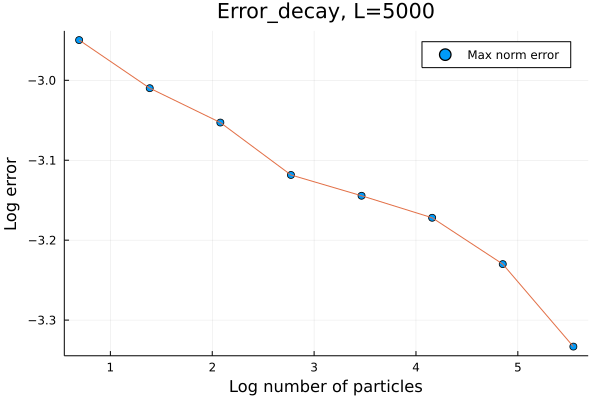

In [199]:
error_plotMax=scatter(log.(Sgrid),log.(er1), label="Max norm error" ); 
plot!(error_plotMax,log.(Sgrid), log.(er1),label=false)
title!("Error_decay, L=5000")
xlabel!("Log number of particles")
ylabel!("Log error")
#png(error_plotMax,"error_plotMax.png")

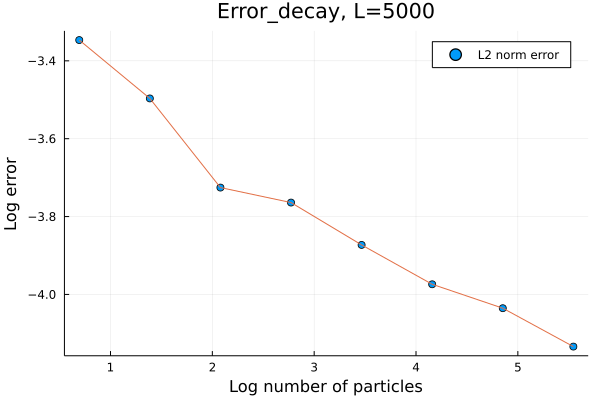

In [200]:
error_plotL2=scatter(log.(Sgrid),log.(er2), label="L2 norm error" ); 
plot!(error_plotL2,log.(Sgrid), log.(er2),label=false)
title!("Error_decay, L=5000")
xlabel!("Log number of particles")
ylabel!("Log error")
#png(error_plotL2,"error_plotL2.png")

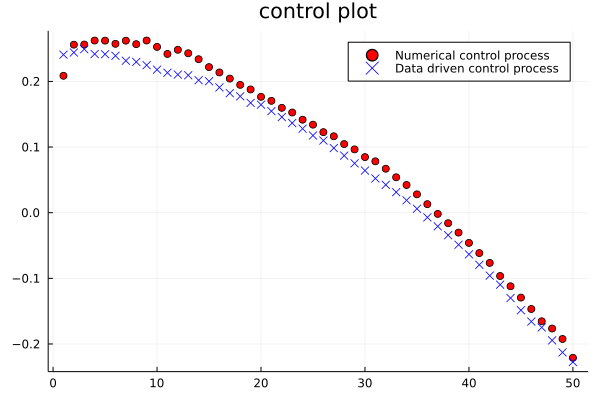

In [16]:
pp=scatter(ccvec,color="red",label="Numerical control process")
scatter!(pp,ctrlp1,markershape=:xcross,markercolor="blue",label="Data driven control process")
title!("control plot")